In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from re import L
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [31]:
# Load the dataset
df = pd.read_csv('E:\Drive\Drilling\MI-127.csv')
df.head()

,depth,rop,wob,rpm_bit,mudweight_in,mudweight_out,P ovb For Soft formation,P ovb For Hard formation,P ovb,d,D-Adjust,PP Zamora Method,PP Eaton Method
0,61,0.1,3.2,71,65.0,66.0,0.88,0.92,0.9,0.73,0.72,8.54,7.9
1,62,0.1,3.2,71,66.0,66.0,0.88,0.92,0.9,0.73,0.73,8.67,7.8
2,63,0.1,3.2,71,66.0,66.0,0.88,0.92,0.9,0.73,0.73,8.67,7.8
3,64,0.2,2.0,,66.0,66.0,0.88,0.92,0.9,0.67,0.67,8.67,7.8
4,65,0.3,1.8,83,66.0,66.0,0.88,0.92,0.9,0.64,0.64,8.67,7.8


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   depth                     2377 non-null   int64  
 1   rop                       2377 non-null   float64
 2   wob                       2377 non-null   float64
 3   rpm_bit                   2377 non-null   object 
 4   mudweight_in              2377 non-null   float64
 5   mudweight_out             2377 non-null   float64
 6   P ovb For Soft formation  2377 non-null   float64
 7   P ovb For Hard formation  2377 non-null   float64
 8   P ovb                     2377 non-null   float64
 9   d                         2377 non-null   float64
 10  D-Adjust                  2377 non-null   float64
 11  PP Zamora Method          2377 non-null   float64
 12  PP Eaton Method           2377 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 241.5+ KB


In [33]:
# Drop unnecessary features
df = df.drop(
    ['P ovb For Soft formation', 'P ovb For Hard formation', 'P ovb', 'd', 'D-Adjust',
     'PP Eaton Method'], axis=1
)
df = df.drop(0, axis=0)
df = df.reset_index(drop=True)
df.head()

,depth,rop,wob,rpm_bit,mudweight_in,mudweight_out,PP Zamora Method
0,62,0.1,3.2,71,66.0,66.0,8.67
1,63,0.1,3.2,71,66.0,66.0,8.67
2,64,0.2,2.0,,66.0,66.0,8.67
3,65,0.3,1.8,83,66.0,66.0,8.67
4,66,0.3,1.4,85,66.0,66.0,8.67


In [34]:
df['rpm_bit'] = pd.to_numeric(df['rpm_bit'], errors='coerce')

In [ ]:
# Plot histograms for normalized data

df_normalized = (df - df.min()) / (df.max() - df.min())  # Min-max normalization

df_normalized.hist(figsize=(15, 10), bins=30, layout=(5, 5))
plt.suptitle("Normalized Feature Distribution", fontsize=16)
plt.show()

# Alternatively, density plot
df_normalized.plot(kind='density', subplots=True, layout=(5, 5), figsize=(15, 10), sharex=False)
plt.suptitle("Normalized Feature Density", fontsize=16)
plt.show()


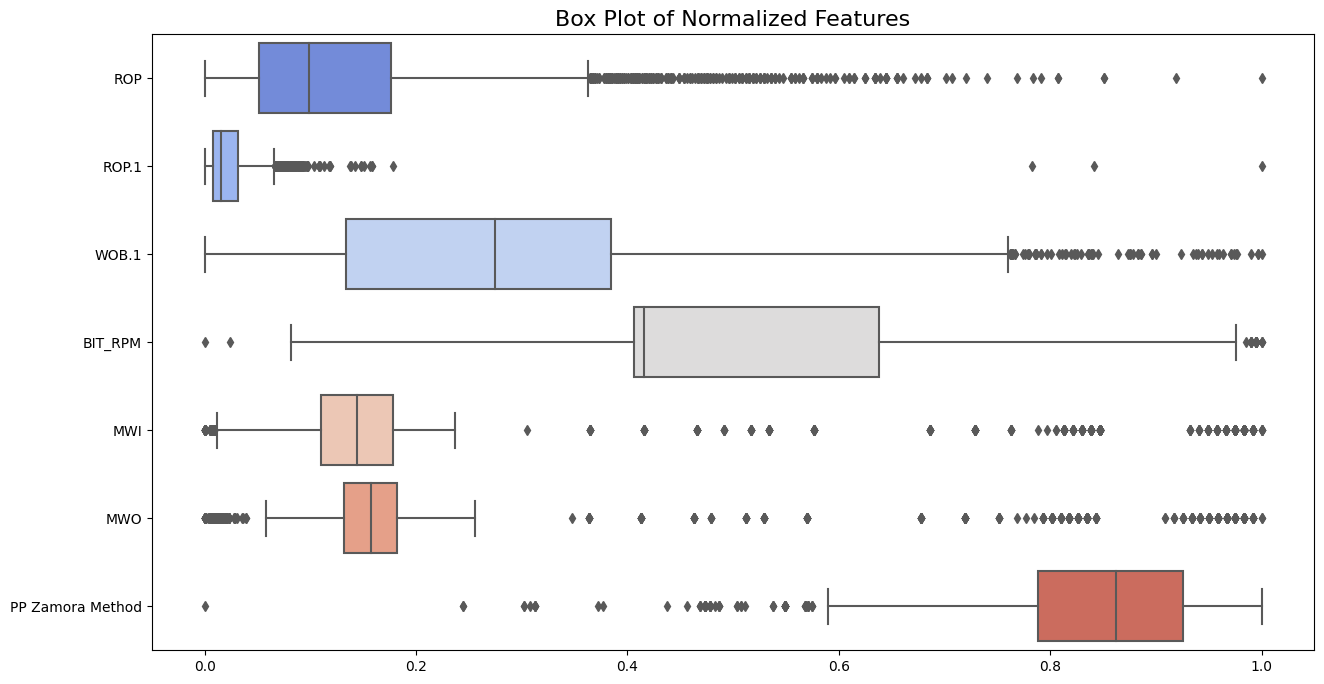

In [6]:
# Box Plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_normalized, orient='h', palette="coolwarm")
plt.title("Box Plot of Normalized Features", fontsize=16)
plt.show()


In [ ]:
# Separate features and target
X = df.drop('PP Zamora Method', axis=1)
y = df['PP Zamora Method']

# Transformation to Reduce Skewness - Apply log(1+x) transformation to reduce skewness
df_transformed = df.copy()
for col in df_transformed.columns:
    df_transformed[col] = np.log1p(df_transformed[col])

X_transformed = df_transformed.drop('PP Zamora Method', axis=1)

# Train/test split on transformed data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("\nBaseline Linear Regression (With Transformation and Scaling):")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

# Ridge Regression (To Handle Outliers and Reduce Overfitting)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_test_pred_ridge = ridge.predict(X_test_scaled)

print("\nRidge Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_ridge))
print("Train R2 Score:", r2_score(y_train, y_train_pred_ridge))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_ridge))
print("Test R2 Score:", r2_score(y_test, y_test_pred_ridge))

# Random Forest Regressor (Handling Nonlinear Relationships and Outliers)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Regressor:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_rf))
print("Train R2 Score:", r2_score(y_train, y_train_pred_rf))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_rf))
print("Test R2 Score:", r2_score(y_test, y_test_pred_rf))

# Check for Overfitting and Underfitting - Calculate performance gaps between train and test sets
lr_train_test_gap = r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred)
ridge_train_test_gap = r2_score(y_train, y_train_pred_ridge) - r2_score(y_test, y_test_pred_ridge)
rf_train_test_gap = r2_score(y_train, y_train_pred_rf) - r2_score(y_test, y_test_pred_rf)

print("\nOverfitting/Underfitting Analysis:")
print(f"Linear Regression Train-Test R2 Gap: {lr_train_test_gap:.4f}")
print(f"Ridge Regression Train-Test R2 Gap: {ridge_train_test_gap:.4f}")
print(f"Random Forest Train-Test R2 Gap: {rf_train_test_gap:.4f}")



Baseline Linear Regression (With Transformation and Scaling):
Train MSE: 1.364066671502974e-06
Train R2 Score: 0.999859404917546
Test MSE: 8.409898833726393e-07
Test R2 Score: 0.9999143132459137

Ridge Regression:
Train MSE: 4.635596185423026e-06
Train R2 Score: 0.9995222066182478
Test MSE: 4.756823036993273e-06
Test R2 Score: 0.9995153369453528

Random Forest Regressor:
Train MSE: 2.5190158990251548e-05
Train R2 Score: 0.9974036368205074
Test MSE: 0.00013112085338489935
Test R2 Score: 0.9866403620998171

Overfitting/Underfitting Analysis:
Linear Regression Train-Test R2 Gap: -0.0001
Ridge Regression Train-Test R2 Gap: 0.0000
Random Forest Train-Test R2 Gap: 0.0108


In [80]:
# Cross-validation for Linear Regression
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nCross-Validation R² Scores for Linear Regression:", cv_scores)
print("Mean CV R² Score:", np.mean(cv_scores))



Cross-Validation R² Scores for Linear Regression: [0.9998805  0.99969942 0.99990668 0.99989144 0.99992163]
Mean CV R² Score: 0.9998599330287856


In [8]:
# Example: New data input 
new_data = {
    'ROP': [19.58],
    'ROP.1': [0.05],
    'WOB.1': [2.33],
    'BIT_RPM': [50],
    'MWI': [64.51],
    'MWO': [65.14],
}

# Convert the dictionary to a DataFrame
new_data_df = pd.DataFrame(new_data)

# Apply Log Transformation
new_data_transformed = new_data_df.copy()
for col in new_data_transformed.columns:
    new_data_transformed[col] = np.log1p(new_data_transformed[col])

# Apply Robust Scaling 
new_data_scaled = scaler.transform(new_data_transformed)

# Make Predictions with Each Model
# Linear Regression Prediction
linear_pred = lr.predict(new_data_scaled)

# Ridge Regression Prediction
ridge_pred = ridge.predict(new_data_scaled)

# Random Forest Prediction
rf_pred = rf.predict(new_data_scaled)

# Display the predictions
print("\nPredictions for New Data:")
print(f"Linear Regression Prediction: {linear_pred[0]}")
print(f"Ridge Regression Prediction: {ridge_pred[0]}")
print(f"Random Forest Prediction: {rf_pred[0]}")



Predictions for New Data:
Linear Regression Prediction: 8.585599090304537
Ridge Regression Prediction: 8.584758942939152
Random Forest Prediction: 8.58683270665427


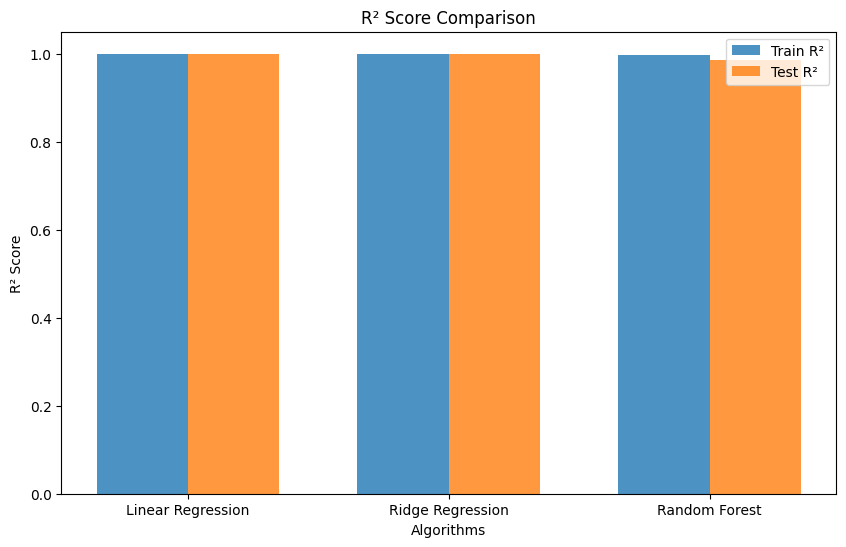

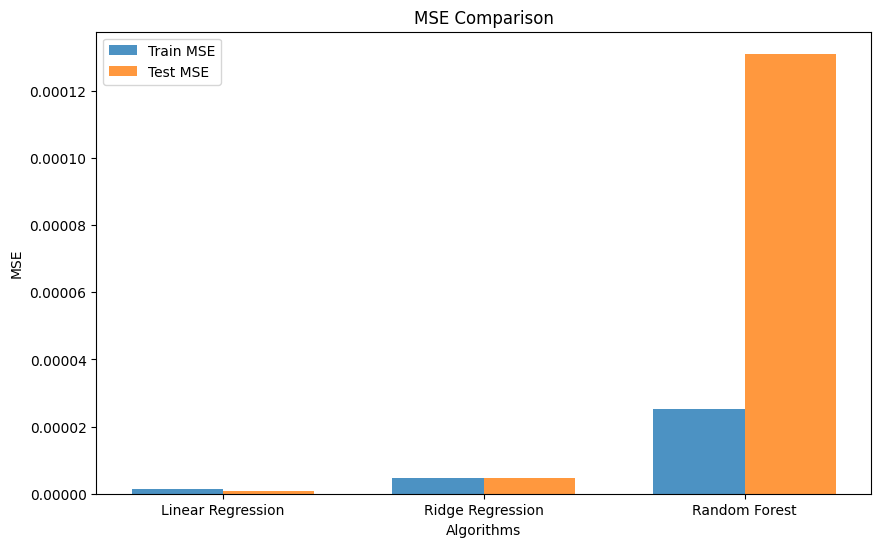

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics from the code
algorithms = ["Linear Regression", "Ridge Regression", "Random Forest"]

# R² scores
r2_train = [0.999859404917546, 0.9995222066182478, 0.9974036368205074]
r2_test = [0.9999143132459137, 0.9995153369453528, 0.9866403620998171]

# MSE values
mse_train = [1.364066671502974e-06, 4.635596185423026e-06, 2.5190158990251548e-05]
mse_test = [8.409898833726393e-07, 4.756823036993273e-06, 0.00013112085338489935]

# R² Score Comparison Bar Chart
x = np.arange(len(algorithms))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, r2_train, width, label='Train R²', alpha=0.8)
bars2 = ax.bar(x + width/2, r2_test, width, label='Test R²', alpha=0.8)

ax.set_xlabel('Algorithms')
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
plt.show()

# MSE Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mse_train, width, label='Train MSE', alpha=0.8)
bars2 = ax.bar(x + width/2, mse_test, width, label='Test MSE', alpha=0.8)

ax.set_xlabel('Algorithms')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
plt.show()
